# Information Maximizing GAN (InfoGAN)

## Theory

Although remarkably effective, the default GAN provides no control over the types of images that are generated.

One natural extension of GAN is to learn a conditional generative distribution. The conditional could be anything, e.g. class label or even another image. However, we need to provide those conditionals manually, somewhat similar to supervised learning. InfoGAN, therefore, attempted to make this conditional learned automatically, instead of telling GAN what that is.

The Information Maximizing GAN, or InfoGAN for short, is an extension to the GAN architecture that introduces control variables that are automatically learned by the architecture and allow control over the generated image, such as style, thickness, and type in the case of generating images of handwritten digits.

InfoGAN is an extension of GANs that learns to represent unlabeled data as codes, aka representation learning. Compare this to vanilla GANs that can only generate samples or to VAEs that learn to both generate code and samples. Representation learning is an important direction for unsupervised learning and GANs are a flexible and powerful interpretation. This makes InfoGAN an interesting stepping stone towards research in representation learning.

The info generative adversarial network, or InfoGAN for short, is an extension to the GAN that attempts to structure the input or latent space for the generator. Specifically, the goal is to add specific semantic meaning to the variables in the latent space.

This is achieved by separating points in the latent space into both noise and latent codes. The latent codes are then used to condition or control specific semantic properties in the generated image.

+ Information Theory

Mutual information (MI) loss function:

$$I(c, G(z, c)) = \mathbb{E}_{c \sim P(c), x \sim G(z, c)} [\log Q(c | X)] + H(c),$$

where $H(c)$ is the entropy of the prior $P(c)$, $G(z, c)$ is the generator net, and $Q(c|X)$ is a neural net that takes image input and producing the conditional $c$.

This MI term fits in the overall GAN loss as a regularization:

$$\min_G \max_D V(D, G) - \lambda I(c, G(z, c))$$

where $V(D, G)$ is GAN loss.


## Advantages and Limitations



## References

D. Barber and F. Agakov, The IM Algorithm : A variational approach to Information Maximization, NIPS 2003.

X. Chen, et al., InfoGAN: Interpretable Representation Learning by Information Maximizing Generative Adversarial Nets, NIPS 2016.

In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True, source_url= 'http://yann.lecun.com/exdb/mnist/')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
mb_size = 128
X_dim = mnist.train.images.shape[1]
h_dim = 128
Z_dim = 100
c_dim = 10

+ Initialization

In [4]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [5]:
X = tf.placeholder(tf.float32, shape=[None, X_dim])

D_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

D_W2 = tf.Variable(xavier_init([h_dim, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

Z = tf.placeholder(tf.float32, shape=[None, Z_dim])
# code
c = tf.placeholder(tf.float32, shape=[None, c_dim])

G_W1 = tf.Variable(xavier_init([Z_dim + c_dim, 2 * h_dim]))
G_b1 = tf.Variable(tf.zeros(shape=[2 * h_dim]))

G_W2 = tf.Variable(xavier_init([2 * h_dim, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

# auxiliary model, 
# which shares all of the same weights as the discriminator model 
# for interpreting an input image, 
# but unlike the discriminator model 
# that predicts whether the image is real or fake, 
# the auxiliary model predicts the control codes 
# that were used to generate the image

Q_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

Q_W2 = tf.Variable(xavier_init([h_dim, c_dim]))
Q_b2 = tf.Variable(tf.zeros(shape=[c_dim]))

theta_Q = [Q_W1, Q_W2, Q_b1, Q_b2]

+ Latent/hidden variable $z$ can sample from any distributions, e.g., uniform distribution or normal distribution.

In [6]:
def sample_Z(m, n):
    
    return np.random.uniform(-1., 1., size=[m, n])

# prior
def sample_c(m):
    
    return np.random.multinomial(1, c_dim*[0.1], size=m)

+ Generator $G$ and Discriminator $D$ are two networks, e.g., ConvNets or Multi-Layer Perceptrons (MLP). Here, Two-Layer Full-Connected Forward Feedback NN.

In [7]:
def generator(z, c):
    inputs = tf.concat(axis=1, values=[z, c])
    G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob

# unconditional discriminator
def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob


def Q(x):
    Q_h1 = tf.nn.relu(tf.matmul(x, Q_W1) + Q_b1)
    Q_logit = tf.matmul(Q_h1, Q_W2) + Q_b2
    Q_prob = tf.nn.softmax(Q_logit)

    return Q_prob

In [8]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [9]:
G_sample = generator(Z, c)

D_real = discriminator(X)
D_fake = discriminator(G_sample)
Q_c_given_x = Q(G_sample)

+ Loss functions

In [10]:
D_loss = -tf.reduce_mean(tf.log(D_real + 1e-8) + tf.log(1 - D_fake + 1e-8))
G_loss = -tf.reduce_mean(tf.log(D_fake + 1e-8))

# H(c) is constant
cross_ent = tf.reduce_mean(-tf.reduce_sum(tf.log(Q_c_given_x + 1e-8) * c, 1))
Q_loss = cross_ent

D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)
Q_solver = tf.train.AdamOptimizer().minimize(Q_loss, var_list=theta_G + theta_Q)

+ Here, $k = 1$

In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('GAN-InfoGAN/'):
    os.makedirs('GAN-InfoGAN/')

avg_costs = {'discriminator': [], 'generator': []}

i = 0

for it in range(50000):
    X_mb, _ = mnist.train.next_batch(mb_size)
    Z_noise = sample_Z(mb_size, Z_dim)
    c_noise = sample_c(mb_size)

    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: Z_noise, c: c_noise})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: Z_noise, c: c_noise})
    
    sess.run([Q_solver], feed_dict={Z: Z_noise, c: c_noise})
    
    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D_loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print('\n')
        
        n_sample = 16
        
        idx = np.random.randint(0, c_dim)
        # categorical control variables, c can also be a continuous variable
        c_noise = np.zeros([n_sample, c_dim])
        c_noise[range(n_sample), idx] = 1

        samples = sess.run(G_sample, feed_dict={Z: sample_Z(n_sample, Z_dim), c: c_noise})
        
        fig = plot(samples)
        plt.savefig('GAN-InfoGAN/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)
        
        avg_costs['discriminator'].append(D_loss_curr / n_sample)
        avg_costs['generator'].append(G_loss_curr / n_sample)

Iter: 0
D_loss: 1.372
G_loss: 2.483


Iter: 1000
D_loss: 0.04791
G_loss: 4.851


Iter: 2000
D_loss: 0.06298
G_loss: 5.643


Iter: 3000
D_loss: 0.1144
G_loss: 4.755


Iter: 4000
D_loss: 0.1229
G_loss: 4.439


Iter: 5000
D_loss: 0.2956
G_loss: 3.781


Iter: 6000
D_loss: 0.2406
G_loss: 4.041


Iter: 7000
D_loss: 0.543
G_loss: 4.047


Iter: 8000
D_loss: 0.7305
G_loss: 3.127


Iter: 9000
D_loss: 0.6205
G_loss: 3.259


Iter: 10000
D_loss: 0.749
G_loss: 2.879


Iter: 11000
D_loss: 0.6825
G_loss: 3.431


Iter: 12000
D_loss: 0.5514
G_loss: 2.857


Iter: 13000
D_loss: 0.8851
G_loss: 2.354


Iter: 14000
D_loss: 0.6296
G_loss: 2.394


Iter: 15000
D_loss: 0.7423
G_loss: 2.205


Iter: 16000
D_loss: 0.771
G_loss: 2.245


Iter: 17000
D_loss: 0.7371
G_loss: 2.182


Iter: 18000
D_loss: 0.9765
G_loss: 1.969


Iter: 19000
D_loss: 0.7807
G_loss: 2.186


Iter: 20000
D_loss: 0.7186
G_loss: 2.271


Iter: 21000
D_loss: 0.9883
G_loss: 1.98


Iter: 22000
D_loss: 0.7883
G_loss: 1.945


Iter: 23000
D_loss: 0.8725


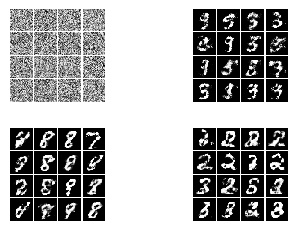

In [12]:
plt.figure()

ax = plt.subplot(221)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan1 = plt.imread('GAN-InfoGAN/000.png')
plt.imshow(gan1, cmap='Greys_r')

ax = plt.subplot(222)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan2 = plt.imread('GAN-InfoGAN/015.png')
plt.imshow(gan2, cmap='Greys_r')

ax = plt.subplot(223)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan3 = plt.imread('GAN-InfoGAN/030.png')
plt.imshow(gan3, cmap='Greys_r')

ax = plt.subplot(224)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan4 = plt.imread('GAN-InfoGAN/045.png')
plt.imshow(gan4, cmap='Greys_r')

plt.show()

+ Performance estimation

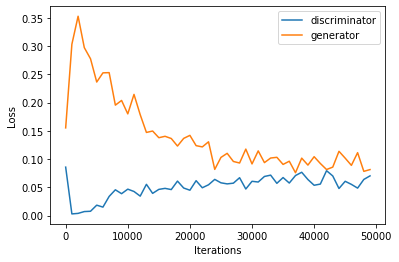

In [13]:
# plotting the learning curves
plt.figure()
plt.plot(np.arange(len(avg_costs['discriminator']))*1000, avg_costs['discriminator'], label='discriminator')
plt.plot(np.arange(len(avg_costs['generator']))*1000, avg_costs['generator'], label='generator')
plt.xlabel(r'Iterations')
plt.ylabel(r'Loss')
plt.legend()
plt.show()